# Vector Search with DINOv3

이 노트북은 **DINOv3** 모델을 사용하여 이미지 검색(Image Retrieval)을 수행하는 예제입니다.
DINOv3는 강력한 Vision Feature를 추출할 수 있지만, 텍스트와 정렬되어 있지 않으므로 **이미지-투-이미지(Image-to-Image)** 검색만 가능합니다.

### 주요 기능
1. **DINOv3 모델 로드**: `facebook/dinov3-convnext-tiny-pretrain-lvd1689m`
2. **이미지 인덱싱**: `./data/images_original` 폴더의 모든 이미지 임베딩 생성
3. **유사 이미지 검색**: 쿼리 이미지와 가장 유사한 이미지를 코사인 유사도로 검색

In [2]:
# 1. 환경 설정 및 라이브러리 임포트
import os
import torch
import numpy as np
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel

# GPU 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [9]:
# Hugging Face 로그인 (Gated Model 접근 권한 필요)
from huggingface_hub import notebook_login
notebook_login()

In [3]:
# 2. DINOv3 모델 로드
from transformers import AutoImageProcessor, AutoModel

pretrained_model_name = "facebook/dinov3-vitl16-pretrain-lvd1689m"
print(f"Loading model: {pretrained_model_name}...")

processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
model = AutoModel.from_pretrained(
    pretrained_model_name, 
    device_map="auto", 
)
print("Model loaded successfully.")

Loading model: facebook/dinov3-vitl16-pretrain-lvd1689m...
Model loaded successfully.


In [13]:
# 3. 임베딩 추출 함수 정의
def get_embedding(image_path):
    try:
        image = PILImage.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(model.device)
        
        with torch.inference_mode():
            outputs = model(**inputs)
            
        # Use pooler_output as requested
        # Note: Some models might not have pooler_output, in that case we might need a fallback
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embedding = outputs.pooler_output
        else:
            # Fallback to CLS token if pooler_output is not available (common in some ViT implementations)
            embedding = outputs.last_hidden_state[:, 0, :]
            
        # Normalize (L2)
        embedding = embedding / embedding.norm(dim=-1, keepdim=True)
        return embedding.cpu()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [24]:
import os
import torch
import pickle
from tqdm import tqdm

image_folder = "./data/images_original"
save_path = "image_embeddings_dinov3.pkl"

image_files = sorted([
    f for f in os.listdir(image_folder)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

db = {"paths": [], "embeddings": []}

for filename in tqdm(image_files):
    path = os.path.join(image_folder, filename)
    emb = get_embedding(path)
    if emb is not None:
        db["paths"].append(path)
        db["embeddings"].append(emb)

if db["embeddings"]:
    db["embeddings"] = torch.cat(db["embeddings"], dim=0)
    with open(save_path, "wb") as f:
        pickle.dump(db, f)
    print(f"Saved {len(db['paths'])} embeddings to {save_path}")
    print(f"Embedding shape: {db['embeddings'].shape}")
else:
    print("No embeddings generated.")

100%|██████████| 5762/5762 [13:21<00:00,  7.19it/s]


Saved 5762 embeddings to image_embeddings_dinov3.pkl
Embedding shape: torch.Size([5762, 1024])


In [1]:
import os
import pickle
import torch
import matplotlib.pyplot as plt
from PIL import Image as PILImage

device = "cuda" if torch.cuda.is_available() else "cpu"

with open("image_embeddings_dinov3.pkl", "rb") as f:
    db = pickle.load(f)

if isinstance(db["embeddings"], torch.Tensor):
    db["embeddings"] = db["embeddings"].to(device)
else:
    db["embeddings"] = torch.tensor(db["embeddings"], device=device)


def search_image(query_input, top_k=5):
    if isinstance(query_input, int):
        query_emb = db["embeddings"][query_input].unsqueeze(0)
        query_img_path = db["paths"][query_input]
        print(f"Query Image (Index {query_input}): {os.path.basename(query_img_path)}")
    elif isinstance(query_input, str):
        query_emb = get_embedding(query_input)
        query_img_path = query_input
        print(f"Query Image (Path): {query_input}")
    else:
        print("Invalid input type.")
        return

    db_embeddings = db["embeddings"]
    sims = (db_embeddings @ query_emb.T).squeeze()
    values, indices = torch.topk(sims, top_k)

    fig, axes = plt.subplots(1, top_k + 1, figsize=(5 * (top_k + 1), 5))

    query_img = PILImage.open(query_img_path).convert("RGB")
    axes[0].imshow(query_img)
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    for i, idx in enumerate(indices):
        res_idx = idx.item()
        res_path = db["paths"][res_idx]
        score = values[i].item()
        try:
            img = PILImage.open(res_path).convert("RGB")
            ax = axes[i + 1]
            ax.imshow(img)
            ax.set_title(f"Top {i+1}\nScore: {score:.4f}")
            ax.axis("off")
        except Exception as e:
            print(f"Error loading {res_path}: {e}")

    plt.tight_layout()
    plt.show()

Query Image (Index 5): 00149032-3dd6-426e-9bc0-d53032536a42.jpg


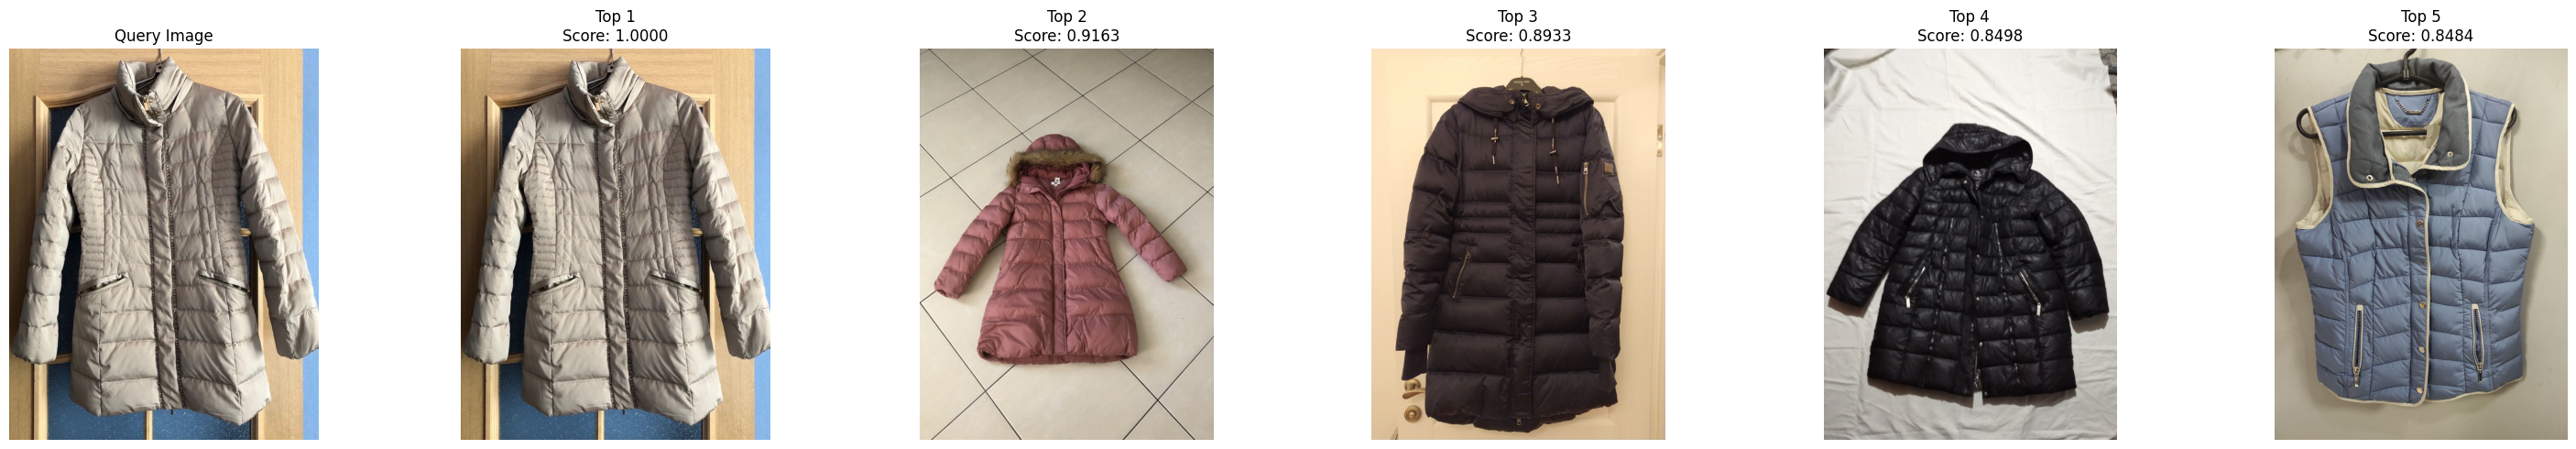

In [28]:
# 6. 검색 테스트
# 인덱싱된 첫 번째 이미지를 쿼리로 사용하여 검색 테스트
if len(db["paths"]) > 0:
    search_image(5, top_k=5)

In [5]:
import os
import pickle
from pathlib import Path
from typing import List, Union

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from transformers import CLIPProcessor, CLIPModel

DB_PATH = "image_embeddings.pkl"
CLIP_ID = "openai/clip-vit-large-patch14"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

full_db = None  # {"paths": List[str], "embeddings": torch.Tensor}

print(f"Loading CLIP model: {CLIP_ID} on {DEVICE}")
clip_model = CLIPModel.from_pretrained(CLIP_ID).to(DEVICE)
clip_model.eval()
clip_processor = CLIPProcessor.from_pretrained(CLIP_ID)


def normalize(x: torch.Tensor) -> torch.Tensor:
    """L2 정규화 (cosine similarity 계산용)."""
    return x / (x.norm(dim=-1, keepdim=True) + 1e-12)

def load_full_db(path: str = DB_PATH) -> None:
    """
    사전 계산된 이미지 임베딩 DB를 로드해서
    전역 변수 full_db에 저장.
    full_db: {"paths": List[str], "embeddings": torch.Tensor}
    """
    global full_db

    db_file = Path(path)
    if not db_file.exists():
        print(f"[load_full_db] Database file not found: {db_file}")
        print("→ 먼저 인덱싱 스크립트를 돌려서 image_embeddings.pkl을 만들어야 합니다.")
        full_db = None
        return

    print(f"[load_full_db] Loading image database from {db_file} ...")
    with db_file.open("rb") as f:
        full_db = pickle.load(f)

    if not isinstance(full_db, dict) or "paths" not in full_db or "embeddings" not in full_db:
        raise ValueError("[load_full_db] Invalid DB format. Expecting dict with 'paths' and 'embeddings'.")

    # 텐서를 올바른 디바이스로 이동
    if isinstance(full_db["embeddings"], torch.Tensor):
        full_db["embeddings"] = full_db["embeddings"].to(DEVICE)
    else:
        full_db["embeddings"] = torch.tensor(full_db["embeddings"], device=DEVICE)

    print(f"[load_full_db] Loaded {len(full_db['paths'])} images.")

ImageInput = Union[str, PILImage.Image]
BatchImageInput = Union[ImageInput, List[ImageInput]]


def image_embed(input_data: BatchImageInput) -> torch.Tensor:
    """
    이미지(경로, PIL.Image, 또는 그 리스트)를 받아
    CLIP 이미지 임베딩을 반환.
    반환 shape: [N, D]
    """
    # 1) 입력을 리스트 형태로 정규화
    if isinstance(input_data, (str, PILImage.Image)):
        inputs_list = [input_data]
    elif isinstance(input_data, list):
        inputs_list = input_data
    else:
        raise TypeError(f"[image_embed] Unsupported input type: {type(input_data)}")

    # 2) 경로 / PIL 각각 처리
    pil_images: List[PILImage.Image] = []
    for item in inputs_list:
        if isinstance(item, str):
            img = PILImage.open(item).convert("RGB")
            pil_images.append(img)
        elif isinstance(item, PILImage.Image):
            pil_images.append(item.convert("RGB"))
        else:
            raise TypeError(f"[image_embed] Unsupported item type in list: {type(item)}")

    # 3) CLIP 전처리 + 임베딩
    with torch.no_grad():
        inputs = clip_processor(images=pil_images, return_tensors="pt", padding=True).to(DEVICE)
        feats = clip_model.get_image_features(**inputs)  # [N, D]
        feats = normalize(feats)

    return feats  # [N, D]

def search_by_image(query_image: ImageInput, top_k: int = 5) -> None:
    """
    한 장의 쿼리 이미지를 넣으면 full_db에서 유사한 이미지 top_k를 시각화.
    """
    global full_db
    if full_db is None:
        load_full_db()
        if full_db is None:
            return

    # 1. 쿼리 임베딩
    query_emb = image_embed(query_image)[0]  # [D]

    # 2. 유사도 계산 (dot = cosine, 이미 정규화 했으므로)
    db_embs = full_db["embeddings"]  # [N, D]
    sims = db_embs @ query_emb  # [N]

    vals, idxs = torch.topk(sims, k=min(top_k, db_embs.shape[0]))
    print(f"[search_by_image] top-{len(idxs)} results")

    # 3. 시각화
    fig, axes = plt.subplots(1, len(idxs), figsize=(4 * len(idxs), 4))
    if len(idxs) == 1:
        axes = [axes]

    for i, (score, idx) in enumerate(zip(vals.tolist(), idxs.tolist())):
        img_path = full_db["paths"][idx]
        try:
            img = PILImage.open(img_path)
        except Exception as e:
            print(f"[search_by_image] Error loading {img_path}: {e}")
            continue

        ax = axes[i]
        ax.imshow(img)
        ax.set_title(f"Top {i+1}\nScore: {score:.4f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

Loading CLIP model: openai/clip-vit-large-patch14 on cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


[search_by_image] top-5 results


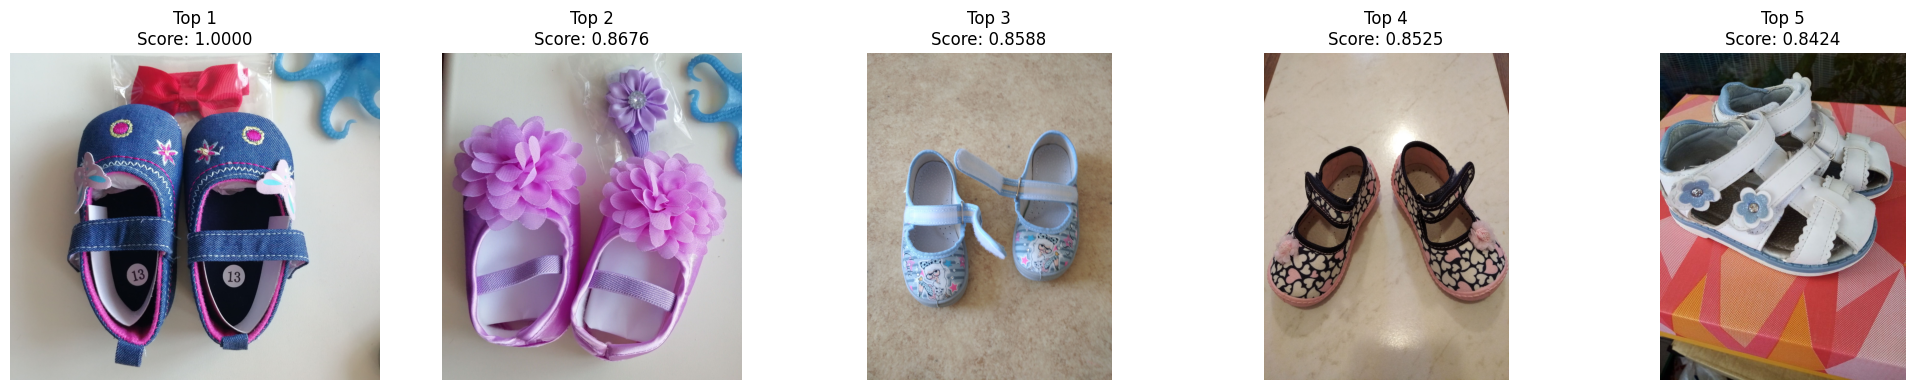

In [17]:
search_by_image("./sample_images_from_kaggle/3.jpg", 5)